In [1]:
import matplotlib.pyplot as plt

from tqdm import tqdm

import mrob
import sklearn
import sklearn.datasets
import numpy as np
import scipy
import scipy.stats
from tqdm import tqdm
from multiprocessing import Pool


Bad key "text.kerning_factor" on line 4 in
/home/nosmokingsurfer/miniconda3/envs/lyft_env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
class TestSE3covMonteCarloCompare:
    def __init__(self):
        pass
        
    def generate_random_inputs(self):
        # initialize random initial/incremental pose and their covariances
        # initial pose and covariance
        self.xi_1 = np.random.randn(6)*1e-1
        self.pose_1 = mrob.geometry.SE3(self.xi_1)
        self.covariance_1 = sklearn.datasets.make_spd_matrix(6)

        #incremental pose and covariance
        self.xi_2 = np.random.randn(6)*1e-2
        self.pose_2 = mrob.geometry.SE3(self.xi_2)
        self.covariance_2 = sklearn.datasets.make_spd_matrix(6)*1e-1

    def test_compound_second_order(self, N=3000):
        # generate random input and store it inside self
        self.generate_random_inputs()
        
        # do the truncated monte carlo sampling of N samples and calculate the resulting variance
        mc_covariance = self.get_truncated_mc(self.pose_1,N,2)
        
        # this code is how 2nd order compounding should be called from SE3Cov class        
        cov = mrob.geometry.SE3Cov(self.pose_1, self.covariance_1)
        cov.compound_2nd_order(self.pose_2, self.covariance_2)
        
        # do the 2nd order compounding:
        # calculate adjoint for T_1 pose
        adj = self.pose_1.adj()
        
        # first I transform sigmas to the Barfoot notation i.e. to (position, rotation) order
        # covariances 
        sigma_2 = mrob.geometry.SE3Cov.notation_transform(self.covariance_1) + \
                            adj@mrob.geometry.SE3Cov.notation_transform(self.covariance_2)@adj.transpose() 
        
        # transform back to MROB notation
        sigma_2 = mrob.geometry.SE3Cov.notation_transform(sigma_2)
        
        error_se3cov = np.linalg.norm(cov.cov() - mc_covariance)

        # error is the Frobenius norm of the difference between covarioance obtained from 
        # truncated monte carlo and compounding formulas 
        error_python = np.linalg.norm(sigma_2 - mc_covariance)
        
        return error_python, error_se3cov

    def test_compound_fourth_order(self,N=3000):
        self.__init__()
        
        mc_covariance = self.get_truncated_mc(self.pose_1,N,4)
        
        cov = mrob.geometry.SE3Cov(self.pose_1, self.covariance_1)
        cov.compound_4th_order(self.pose_2, self.covariance_2)
        
        error = np.linalg.norm(cov.cov() - mc_covariance)
        return error

    def get_truncated_mc(self, T, N, order):
        
        #by given covariances I generate two normal distributions with zero bias
        norm_var_1 = scipy.stats.multivariate_normal([0,0,0,0,0,0],self.covariance_1,allow_singular=True)
        norm_var_2 = scipy.stats.multivariate_normal([0,0,0,0,0,0],self.covariance_2,allow_singular=True)

        # generate N samples for xi_1 and xi_2
        # Note: these variables are at the MROB notation yet
        xi_1 = norm_var_1.rvs(N)
        xi_2 = norm_var_2.rvs(N)

        # switch to Barfoot notation
        permutation = [3,4,5,0,1,2]
        idx = np.empty_like(permutation)
        idx[permutation] = range(len(permutation))

        xi_1 = xi_1[:,idx]
        xi_2 = xi_2[:,idx]

        # calculating the adjoint matrix from pose_1
        adj = T.adj()
        
        # multiplying xi_2 points by adjoint from the left
        xi_2 = [adj@xi for xi in xi_2]

        # calculating the covariance by definition - summing up all pairs of outer products of random values
        covariance = np.zeros((6,6))
        for i in (range(N)):
            covariance += xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose() \
                        + xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose()

            if order == 4:
                xi_1_w = mrob.geometry.curley_wedge(xi_1[i])
                xi_2_w = mrob.geometry.curley_wedge(xi_2[i])
                
                covariance += 1./12.*((xi_1_w@xi_1_w)@(xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose()) \
                    + (xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose())@(xi_1_w@xi_1_w).transpose() \
                    + (xi_2_w@xi_2_w)@(xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose()) \
                    + (xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose())@(xi_2_w@xi_2_w).transpose())\
                + 1./4.*xi_1_w@(xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose())@xi_1_w.transpose()
        
        # nomalizing the covariance by the number of samples
        covariance = covariance / N

        # switching back to the MROB notation
        covariance = mrob.geometry.SE3Cov.notation_transform(covariance)
        return covariance


In [3]:
test = TestSE3covMonteCarloCompare()

In [14]:
# N = np.linspace(10,300_000,num=5)
N = np.logspace(1,6,num=7)
M = 10

In [5]:
errors_2_se3cov = np.zeros((M,len(N)))
errors_2_python = np.zeros((M,len(N)))

for n in tqdm(range(len(N))):
    for m in range(M):
        errors_2_python[m,n], errors_2_se3cov[m,n] = test.test_compound_second_order(int(N[n]))

100%|██████████| 7/7 [01:26<00:00, 12.31s/it]


In [6]:
errors_4_se3cov = np.zeros((M,len(N)))

for n in tqdm(range(len(N))):
    for m in range(M):
        errors_4_se3cov[m,n] = test.test_compound_fourth_order(int(N[n]))

100%|██████████| 7/7 [07:24<00:00, 63.49s/it] 


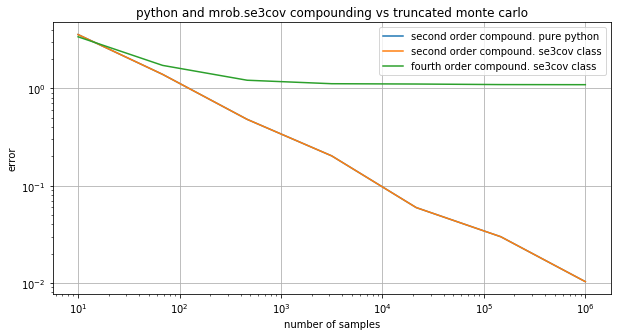

In [18]:
plt.figure(figsize=(10,5))
plt.loglog(N, np.mean(errors_2_python, axis=0), label='second order compound. pure python')
plt.loglog(N, np.mean(errors_2_se3cov, axis=0), label='second order compound. se3cov class')
plt.loglog(N, np.mean(errors_4_se3cov, axis=0), label='fourth order compound. se3cov class')
plt.title('python and mrob.se3cov compounding vs truncated monte carlo')
plt.xlabel('number of samples')
plt.ylabel('error')
plt.legend()
plt.grid()

In [19]:
print('2nd order, se3cov class:',np.mean(errors_2_se3cov,axis=0)) # mrob::SE3cov.second_order
print('2nd order, python:',np.mean(errors_2_python,axis=0)) # pure python
print('4th order, se3cov class:',np.mean(errors_4_se3cov,axis=0)) # mrob::Se3cov.fourth_order

2nd order, se3cov class: [3.56483826 1.39038964 0.47972642 0.20228579 0.05953389 0.02988228
 0.01032891]
2nd order, python: [3.56483826 1.39038964 0.47972642 0.20228579 0.05953389 0.02988228
 0.01032891]
4th order, se3cov class: [3.380788   1.71919025 1.21013993 1.1145241  1.1064301  1.09195229
 1.08919145]


# 6D distribution covariance estimation

In [20]:
n_samples = 1_000_000
covariance_1 = sklearn.datasets.make_spd_matrix(6)
norm_var_1 = scipy.stats.multivariate_normal([0,0,0,0,0,0],covariance_1,allow_singular=True)

xi_1 = norm_var_1.rvs(n_samples)
xi_1.shape

(1000000, 6)

In [22]:
covariance = np.zeros((6,6))
for i in tqdm(range(n_samples)):
    covariance += xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose()
covariance = covariance / n_samples
np.linalg.norm(covariance - covariance_1)

100%|██████████| 1000000/1000000 [00:03<00:00, 282117.04it/s]


0.012558412277299702